In [507]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
#import seaborn as sns
import numpy as np
import uuid

In [263]:
from rdflib import ConjunctiveGraph, Graph, Namespace, URIRef, Literal
import rdflib
XSD = Namespace('http://www.w3.org/2001/XMLSchema#')

In [473]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [552]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(0.001),
        # use complete metric names
        metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def build_model(input_size):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[input_size]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # 'acc', tf.keras.metrics.MeanSquaredError()

  return model

""" displays prediction diagram by applying model of source room to 
data of target room
"""
def prediction_graph(source_room, target_room):
    
    test_predictions = rooms[source_room]['model'].predict(rooms[target_room]['normed_test_data']).flatten()

    a = plt.axes(aspect='equal')
    plt.scatter(rooms[target_room]['test_labels'], test_predictions)
    plt.xlabel('True Values [Occupants]')
    plt.ylabel('Predictions [Occupants]')
    lims = [0, 80]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

In [6]:
""" Merge time columns based on given interval
"""
def merge_time(input_df, data_column, interval = 30, time_filter = True):
    input_df['merged_time'] = input_df.apply(lambda row: str(row['year']) +
                         str(row['month']).zfill(2) + 
                         str(row['day']).zfill(2) +
                         row['time'][:2] + 
                         str(int(row['time'][3:5]) // interval).zfill(2), axis=1)
    
    if time_filter:
        drop_index = input_df[input_df['time'].map(lambda row: int(row[:2]) < 6 or int(row[:2]) > 14)].index
        input_df.drop(drop_index , inplace=True)
    
    
    return input_df.groupby(['merged_time'])[data_column].mean()
    

""" normalize data
"""
def norm(x, x_stats):
  return (x - x_stats['mean']) / x_stats['std']
    

In [7]:
def build_dataset(room):

    ### filled
    occupancy_file = "/Users/amin/Downloads/Dataset/filleddata/occupant_count_room_%d.csv"%room
    co2_file = "/Users/amin/Downloads/Dataset/filleddata/co2_room_%d.csv"%room
    temperature_file = "/Users/amin/Downloads/Dataset/filleddata/temperature_room_%d.csv"%room
    #illuminance_file = "/Users/amin/Downloads/Dataset/filleddata/Illuminance_room_%d.csv"%room
    humidity_file = "/Users/amin/Downloads/Dataset/filleddata/humidity_room_%d.csv"%room

    ### original
    #occupancy_file = "/Users/amin/Downloads/Dataset/original/occupant_count_room_1.csv"
    #co2_file = "/Users/amin/Downloads/Dataset/original/co2_room_1.csv"

    occ_columns = ['year', 'month', 'time', 'day', 'workday', 'occupancy']
    co2_columns = ['year', 'month', 'time', 'day', 'workday', 'co2']
    #tmp_columns = ['year', 'month', 'time', 'day', 'workday', 'temperature']
    #ill_columns = ['year', 'month', 'time', 'day', 'workday', 'illuminance']
    #hum_columns = ['year', 'month', 'time', 'day', 'workday', 'humidity']

    occ_df = pd.read_csv(occupancy_file, names=occ_columns, skiprows=1)
    co2_df = pd.read_csv(co2_file, names=co2_columns, skiprows=1)
    #tmp_df = pd.read_csv(temperature_file, names=tmp_columns, skiprows=1)
    #ill_df = pd.read_csv(illuminance_file, names=ill_columns, skiprows=1)
    #hum_df = pd.read_csv(humidity_file, names=hum_columns, skiprows=1)
    
    
    occ_grouped = merge_time(occ_df, 'occupancy')
    co2_grouped = merge_time(co2_df, 'co2')
    #tmp_grouped = merge_time(tmp_df, 'temperature')
    #ill_grouped = merge_time(ill_df, 'illuminance')
    #hum_grouped = merge_time(hum_df, 'humidity')
    
    
    #dataset = pd.concat([occ_grouped, co2_grouped, tmp_grouped, ill_grouped, hum_grouped], axis=1, sort=False)
    dataset = pd.concat([occ_grouped, co2_grouped], axis=1, sort=False)
    dataset['occupancy'] = dataset['occupancy'].round()

    # simplifying occupancy in 10X groups 
    #dataset['occupancy'] = dataset['occupancy']//10


    # simplifying occupancy in 20X groups 
    #dataset['occupancy'] = dataset['occupancy']//20

    # simplifying occupancy in 5X groups 
    #dataset['occupancy'] = dataset['occupancy']//5 
    
    return dataset

In [8]:
room_dataset = {1: build_dataset(1), 2:build_dataset(2), 3:build_dataset(3)}

In [10]:
room_id = 1
dataset = room_dataset[room_id].copy()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# dataset statistics
train_stats = train_dataset.describe()
train_stats.pop("occupancy")
train_stats = train_stats.transpose()
print(train_stats)

#split featured from lables
train_labels = train_dataset.pop('occupancy')
test_labels = test_dataset.pop('occupancy')

# normalize the data
normed_train_data = norm(train_dataset, train_stats)
normed_test_data = norm(test_dataset, train_stats)

     count        mean         std         min        25%         50%  \
co2  634.0  646.489927  133.201777  450.613337  521.43466  634.767994   

           75%         max  
co2  757.16534  992.810677  


In [11]:
model = build_model(len(train_dataset.keys()))
model.summary()

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.1203,  loss:807.5320,  mae:20.1766,  mse:807.5320,  val_acc:0.0315,  val_loss:806.8320,  val_mae:20.1976,  val_mse:806.8320,  
..........................................................................

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
69,212.747009,10.358898,212.747009,0.100592,243.602295,11.286337,243.602295,0.031496,69
70,212.699753,10.388831,212.699753,0.100592,243.540222,11.277650,243.540222,0.031496,70
71,212.957581,10.399727,212.957581,0.100592,243.541702,11.306745,243.541702,0.031496,71
72,212.316315,10.388264,212.316315,0.100592,243.758057,11.234996,243.758057,0.031496,72
73,212.341553,10.381507,212.341553,0.100592,243.811005,11.228868,243.811005,0.031496,73


In [584]:
# build models and datasets
rooms = {}

for room_id in [1,2,3]:
    
    # build dataset
    dataset = room_dataset[room_id].copy()
    train_dataset = dataset.sample(frac=0.8,random_state=0)
    test_dataset = dataset.drop(train_dataset.index)

    
    ds_uuid = uuid.uuid4().hex
    ds_file = 'dataset/ds_{}.h5'.format(ds_uuid)
    store = pd.HDFStore(ds_file)
    store['train'] = train_dataset
    store['test'] = test_dataset
    store.close()
    rooms
    

    #split featured from lables
    train_labels = train_dataset.pop('occupancy')
    test_labels = test_dataset.pop('occupancy')


    # normalization layer
    co2_feature = np.array(train_dataset['co2'])
    co2_normalizer = preprocessing.Normalization(input_shape=[1,])
    co2_normalizer.adapt(co2_feature)
    
    model = build_and_compile_model(co2_normalizer)
    
    
    model.summary()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(train_dataset, train_labels, 
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    # store model
    model_uuid = uuid.uuid4().hex
    model_file = 'model/model_{}.h5'.format(model_uuid)
    model.save(model_file)

    #loss, mae, mse, acc = model.evaluate(normed_test_data, test_labels, verbose=2)
    rooms[room_id] = {
        'test_data' : test_dataset, 
        'test_labels' : test_labels, 
        'model': model, 
        'model_file' : model_file, 
        'dataset_uuid': ds_uuid
    }

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_28 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_93 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_94 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________

Epoch: 0, loss:815.7079,  mean_absolute_error:20.3290,  mean_squared_error:815.7079,  val_loss:824.0128,  val_mean_absolute_error:20.4505,  val_mean_squared_error:824.0128,  
.........................................................................

Text(0, 0.5, 'MAE [Occupants]')

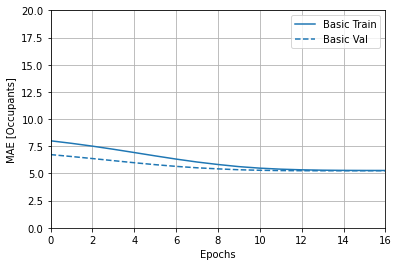

In [575]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'mean_absolute_error')
plt.ylim([0, 20])
plt.ylabel('MAE [Occupants]')

In [571]:
room_id = 1
loss, mae, mse = rooms[room_id]['model'].evaluate(rooms[room_id]['test_data'], rooms[room_id]['test_labels'], verbose=2)
print("Testing set Mean Abs Error: {:5.2f} CO2".format(mae))

5/5 - 0s - loss: 156.4352 - mean_absolute_error: 9.2511 - mean_squared_error: 156.4352
Testing set Mean Abs Error:  9.25 CO2


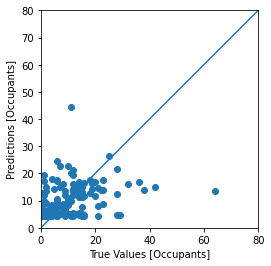

In [585]:
test_predictions = model.predict(rooms[room_id]['test_data']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Occupants]')
plt.ylabel('Predictions [Occupants]')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

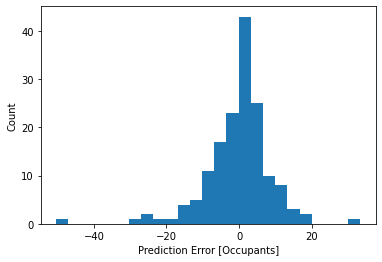

In [586]:
#error = test_predictions - test_labels
error = test_predictions - rooms[room_id]['test_labels']
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Occupants]")
_ = plt.ylabel("Count")

In [37]:
dataset.isna().sum()

occupancy      0
co2            0
temperature    0
humidity       0
dtype: int64

In [ ]:
# Preparing dataset for overlay SNS diagram
room1_dataset = room_dataset[1].copy()
room2_dataset = room_dataset[2].copy()
room3_dataset = room_dataset[3].copy()

room1_dataset['room'] = 1
room2_dataset['room'] = 2
room3_dataset['room'] = 3

dataset=room1_dataset.copy()
dataset = dataset.append(room2_dataset)
dataset = dataset.append(room3_dataset)

sns.pairplot(dataset, diag_kind="kde", hue="room",  plot_kws=dict(alpha=0.2))

<Figure size 432x288 with 0 Axes>

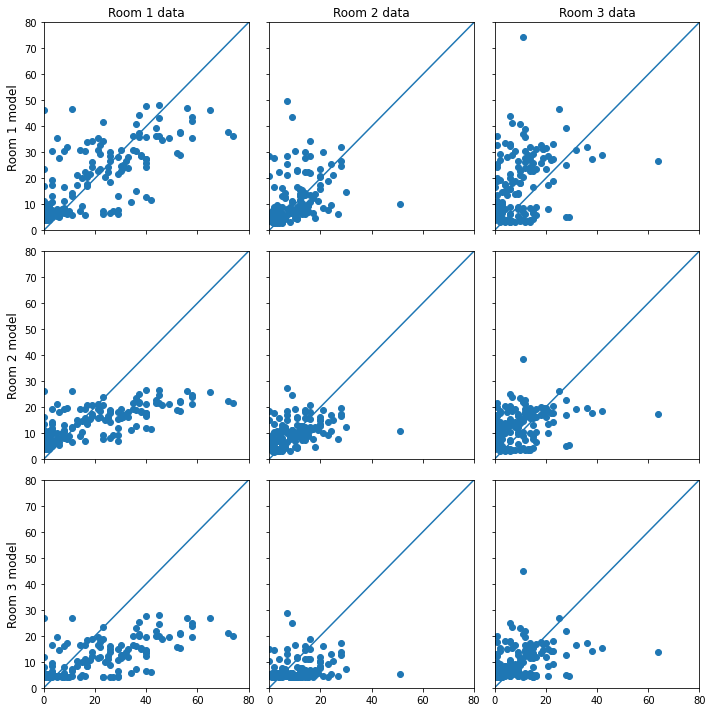

In [578]:
# Drawing prediction subplots
fig = plt.figure()
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)

cols = ['Room 1 data', 'Room 2 data', 'Room 3 data']
rows = ['Room 1 model', 'Room 2 model', 'Room 3 model']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.tight_layout()


for source_room in [1,2,3]:
    for target_room in [1,2,3]:
        test_predictions = rooms[source_room]['model'].predict(rooms[target_room]['test_data']).flatten()
        axs[source_room - 1 , target_room - 1].scatter(rooms[target_room]['test_labels'], test_predictions)
        _ = axs[source_room - 1 , target_room - 1].plot(lims, lims)
        #axs[source_room - 1, target_room -1].set_xlabel('True Values [Occupants]')
plt.show()

5/5 - 0s - loss: 156.5588 - mean_absolute_error: 9.1999 - mean_squared_error: 156.5588
5/5 - 0s - loss: 86.2508 - mean_absolute_error: 5.9402 - mean_squared_error: 86.2508
5/5 - 0s - loss: 209.1591 - mean_absolute_error: 11.0698 - mean_squared_error: 209.1591
5/5 - 0s - loss: 228.5449 - mean_absolute_error: 11.3156 - mean_squared_error: 228.5449
5/5 - 0s - loss: 49.5743 - mean_absolute_error: 4.9042 - mean_squared_error: 49.5743
5/5 - 0s - loss: 96.4649 - mean_absolute_error: 7.6409 - mean_squared_error: 96.4649
5/5 - 0s - loss: 271.8151 - mean_absolute_error: 12.0869 - mean_squared_error: 271.8151
5/5 - 0s - loss: 68.8310 - mean_absolute_error: 5.9800 - mean_squared_error: 68.8310
5/5 - 0s - loss: 84.2308 - mean_absolute_error: 6.2247 - mean_squared_error: 84.2308


<Figure size 432x288 with 0 Axes>

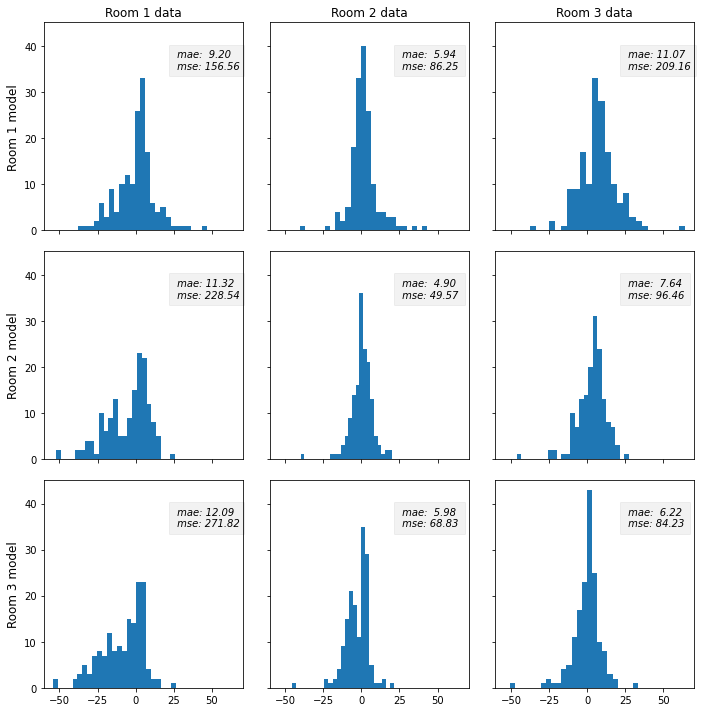

In [587]:
# Drawing error subplots
fig = plt.figure()
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

cols = ['Room 1 data', 'Room 2 data', 'Room 3 data']
rows = ['Room 1 model', 'Room 2 model', 'Room 3 model']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.tight_layout()

cnt = 1
for source_room in [1,2,3]:
    
    source_model = rooms[source_room]['model']

    for target_room in [1,2,3]:
        
        loss, mae, mse = source_model.evaluate(rooms[target_room]['test_data'], rooms[target_room]['test_labels'], verbose=2)
        axs[source_room - 1 , target_room - 1].text(25, 35, ' mae: {:5.2f} \n mse: {:5.2f}'.format(mae, mse), style='italic',
            bbox={'facecolor': 'black', 'alpha': 0.05, 'pad': 5})
        
        test_predictions = source_model.predict(rooms[target_room]['test_data']).flatten()
        error = test_predictions - rooms[target_room]['test_labels'] 
        axs[source_room - 1 , target_room - 1].hist(error, bins = 25)
        
        #plt.xlabel("Prediction Error [Occupants]")
        #_ = plt.ylabel("Count")
        cnt += 1
    
        
plt.show()

In [133]:
tf_model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_3_input"}}, {"class_name": "Dense", "config": {"name": "dense_3", "trainable": true, "batch_input_shape": [null, 1], "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_4", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "

In [35]:
{m.name: m.result() for m in tf_model.metrics}

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=48.950825>,
 'mae': <tf.Tensor: shape=(), dtype=float32, numpy=5.2487955>,
 'mse': <tf.Tensor: shape=(), dtype=float32, numpy=48.950825>,
 'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.10236221>}

In [32]:
tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


# Add Model to Ontology

In [50]:
RDF        = Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#')
RDFS       = Namespace('http://www.w3.org/2000/01/rdf-schema#')
OWL        = Namespace('http://www.w3.org/2002/07/owl#')
XML        = Namespace('http://www.w3.org/XML/1998/namespace')
XSD        = Namespace('http://www.w3.org/2001/XMLSchema#')
DCTERMS    = Namespace('http://purl.org/dc/terms/')

BRICK      = Namespace('https://brickschema.org/schema/1.0.3/Brick#')
BRICKFRAME = Namespace('https://brickschema.org/schema/1.0.3/BrickFrame#')
BRICKTAG   = Namespace('https://brickschema.org/schema/1.0.3/BrickTag#')
BRICKUSE   = Namespace('https://brickschema.org/schema/1.0.3/BrickUse#')

MLS        = Namespace('http://www.w3.org/ns/mls#')

# The occupant Brick namespace
NS         = Namespace('http://inter-space.org/learning_model#')

In [597]:
class Ontology:

    # prefixes
    NS = {
        'rdf'        : Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#'),
        'rdfs'       : Namespace('http://www.w3.org/2000/01/rdf-schema#'),
        'owl'        : Namespace('http://www.w3.org/2002/07/owl#'),
        'xml'        : Namespace('http://www.w3.org/XML/1998/namespace'),
        'xsd'        : Namespace('http://www.w3.org/2001/XMLSchema#'),
        'dcterms'    : Namespace('http://purl.org/dc/terms/'),
        'brick'      : Namespace('https://brickschema.org/schema/1.0.3/Brick#'),
        'brickframe' : Namespace('https://brickschema.org/schema/1.0.3/BrickFrame#'),
        'bricktag'   : Namespace('https://brickschema.org/schema/1.0.3/BrickTag#'),
        'brickuse'   : Namespace('https://brickschema.org/schema/1.0.3/BrickUse#'),
        'mls'        : Namespace('http://www.w3.org/ns/mls#'),
        'isl'         : Namespace('http://inter-space.org/learning_model#')
    }
    
    
    
    metrics = {
        'mae': 'MeanAbsoluteError',
        'mean_absolute_error': 'MeanAbsoluteError',

        'mse': 'MeanSquaredError',
        'mean_squared_error': 'MeanSquaredError'
    }

    
    def __init__(self, conjunctive = True):
        
        if conjunctive: 
            # create conjunctive graph for NQuads serialization
            self.g = ConjunctiveGraph()
        else:
            self.g = Graph()

        for prefix in self.NS:
            self.g.bind(prefix, self.NS[prefix])
            
        # add all building-nutral triples
        # TODO: later add to base.ttl and load it.
        #for elm in [self.NS['mls'].MinValue, self.NS['mls'].MaxValue, self.NS['mls'].StdValue, self.NS['mls'].MeanValue]:
        #    self.g.add((elm, self.NS['rdf'].type, self.NS['owl'].Class))
        #    self.g.add((elm, self.NS['rdfs'].subClassOf, self.NS['mls'].FeatureCharacteristic))

        
    def load_ttl(self, ttl_file):
        self.g.parse(ttl_file, format="turtle")
          
            
    def get_uuid(self):
        return uuid.uuid4().hex
    
    
    def get_building(self):
        return next(self.g.subjects(self.NS['rdf'].type, self.NS['brick'].Building))
    
    
    def add_space(self, room_name, statements):
        space = self.NS['isl'][room_name]
        self.g.add((space, RDF.type, self.NS['brick'].Room))
        
        for p,o in statements:
            self.g.add((space, self.entity(p), self.entity(o)))
        
        building = self.get_building()
        self.g.add((building, self.NS['brickframe'].Contains, space))
        return space
        
        
    def add_sensor(self, sensor_name, statements):
        sensor = self.NS['isl'][sensor_name]
        
        for p,o in statements:
            self.g.add((sensor, self.entity(p), self.entity(o)))
        
        
        
    
    """ 
    Run is an ML flow that applies a model in a specific dataset to achive the given task.
    If it is a trainig run, there wis no input model. Input model is for evaluation and 
    test purposes. 
        - metrics: metrics of the test run. For adding a trained model should be None
        
    """    
    def add_run(self,  model_filename, task_name, split_id, test_metrics = None):
        
        train_run = split_id.endswith('/train')
        
        # tensorflow model
        tf_model = tf.keras.models.load_model(model_filename)
        
        # model
        model_id = self.__extract_id(model_filename)
        model = self.NS['isl'][model_id]
        
        if train_run:
            self.g.add((model, self.NS['rdf'].type, self.NS['mls'].Model))
            self.g.add((model, self.NS['dcterms'].identifier, Literal(model_filename)))
        
        # model run
        run_id = 'run_' + self.get_uuid()
        model_run = self.NS['isl'][run_id]
        self.g.add((model_run, self.NS['rdf'].type, self.NS['mls'].Run))
        
        # model evaluations
        eval_id = run_id + '/eval'
        model_evaluation = self.NS['isl'][eval_id]
        self.g.add((model_evaluation, self.NS['rdf'].type, self.NS['mls'].ModelEvaluation))


        for m in tf_model.metrics:
            if m.name in self.metrics:
                metric_name = self.metrics[m.name]
                metric_class = self.NS['mls'][metric_name]

                metric = self.NS['isl'][eval_id + '/' + m.name]
                self.g.add((metric, self.NS['rdf'].type, metric_class))
                
                if train_run:
                    self.g.add((metric, self.NS['mls'].hasValue, Literal(m.result().numpy(), datatype=self.NS['xsd'].float) ))
                else:
                    self.g.add((metric, self.NS['mls'].hasValue, Literal(test_metrics[m.name], datatype=self.NS['xsd'].float) ))

                self.g.add((model_evaluation, self.NS['mls'].specifiedBy, metric))
        
        # task
        task = self.NS['isl'][task_name]
        self.g.add((model_run, self.NS['mls'].achieves, task))
        
        self.g.add((model_run, self.NS['mls'].hasInput, self.NS['isl'][split_id]))
        self.g.add((model_run, self.NS['mls'].hasOutput, model))
        self.g.add((model_run, self.NS['mls'].hasOutput, model_evaluation))
        self.g.add((model_run, self.NS['mls'].executes, self.NS['isl']['tensorflow']))
        
        backend = type(tf_model).__module__+'.'+type(tf_model).__name__
        self.g.add((model_run, self.NS['mls'].realizes, Literal(backend)))
        
        return model_run
        
    
    """
    Receive the dataset as dataframe and add it to ontology. 
    Also the references to BRICK entities (e.g. datatype and sensors) can be added.
    """
    def add_dataset(self, ds_id, brick_refs=None):
        
        stats_dic = {
            'min': {'class': self.NS['mls'].MinValue, 'datatype': self.NS['xsd'].float },
            'max': {'class': self.NS['mls'].MaxValue, 'datatype': self.NS['xsd'].float },
            'mean': {'class': self.NS['mls'].MeanValue, 'datatype': self.NS['xsd'].float },
            'std': {'class': self.NS['mls'].StdValue, 'datatype': self.NS['xsd'].float }
        }
        
        split_dict = {
            'test' : 'TestDataset',
            'train': 'TrainDataset',
            'validation': 'ValidationDataset'
        }

        dataset_filename = 'dataset/ds_{}.h5'.format(ds_id)
        
        ds = pd.HDFStore(dataset_filename, 'r')
        split_keys = [k[1:] for k in ds.keys()]
        
        # get structure from the first data split
        key0 = split_keys[0]

        dataset_uri = self.NS['isl'][ds_id]
        self.g.add((dataset_uri, self.NS['rdf'].type, self.NS['mls'].Dataset))
        
        
        for col in ds[key0].columns:
            
            feature = self.NS['isl'][ds_id+'/'+col]
            self.g.add((feature, self.NS['rdf'].type, self.NS['mls'].Feature))
            self.g.add((dataset_uri, self.NS['mls'].hasPart, feature))

            
            # add brick references if any
            if brick_refs and col in brick_refs:
                statements = brick_refs[col]
                for p,o in statements:
                    self.g.add((feature, self.entity(p), self.entity(o)))
                

        
        # add dataset splits    
        for key in split_keys:
            # add split definition
            split_id = ds_id + '/' + key
            split = self.NS['isl'][split_id]
            split_class = split_dict[key]
            self.g.add((split, self.NS['rdf'].type, self.NS['mls'][split_class]))
            self.g.add((dataset_uri, self.NS['mls'].hasSplit, split))
            
           
            # add number of instances to dataset split
            rows, _ = ds[key].shape
            val = self.NS['isl'][split_id+'/'+'count']
            self.g.add((val, self.NS['rdf'].type, self.NS['mls'].DatasetCharacteristic))
            self.g.add((val, self.NS['mls'].hasValue, Literal(rows, datatype=self.NS['xsd'].long) ))
            self.g.add((split, self.NS['mls'].hasQuality, val))

        
            stats = ds[key].describe()
            
            for col in ds[key].columns:
                column = self.NS['isl'][split_id+'/'+col]
                feature = self.NS['isl'][ds_id+'/'+col]
                
                self.g.add((column, self.NS['rdf'].type, self.NS['mls'].Column))
                self.g.add((column, self.NS['mls'].specifiedBy, feature))


                for ind in stats_dic: # stat indicators

                    # quality indicators
                    val = self.NS['isl'][split_id+'/'+col+'/'+ind]
                    self.g.add((val, self.NS['rdf'].type, stats_dic[ind]['class']))
                    self.g.add((val, self.NS['mls'].hasValue, Literal(stats[col][ind], datatype=stats_dic[ind]['datatype']) ))

                    self.g.add((column, self.NS['mls'].hasQuality, val))
                    
        ds.close()
        return


    """ extract entity id from filename
    """
    def __extract_id(self, filename):
        start = filename.rfind('/') + 1
        end = filename.rfind('.')
        return filename[start:end]




    """ Geneartes a qualified entity for the given name with prefix
    """
    def entity(self, name):
        if type(name) in [Literal, URIRef]:
            return name
        elif ':' in name:
            prefix, label = name.split(':')
            return self.NS[prefix][label]
        else:
            return Literal(name, datatype=self.NS['xsd'].string)
        
        
    def serialize(self):
        print(self.g.serialize(format='n3').decode("utf-8"))
        
    def save_ttl(self, file_name):
        formats = {
            'ttl': 'turtle',
            'nq':'nquads'
        }
        _, ext = file_name.split('.')
        if ext in formats:
            self.g.serialize(destination='ontology/'+file_name, format=formats[ext])
        else:
            print('Unknown file extension!')
            
            


In [598]:
ont = Ontology()
ont.load_ttl('ontology/base_graph.ttl')
#ont.add_dataset(train_dataset)

In [599]:
for room_id, room in rooms.items():
    
    #dataset = room_dataset[room_id].copy()
    #train_dataset = dataset.sample(frac=0.8,random_state=0)
    #test_dataset = dataset.drop(train_dataset.index)
    
    #ds_uuid = uuid.uuid4().hex
    #filename = 'dataset/ds_{}.h5'.format(ds_uuid)
    #store = pd.HDFStore(filename)
    #store['train'] = train_dataset
    #store['test'] = test_dataset
    #store.close()
    

    brick_ref = {
        'co2': [
            ('rdf:type', 'brick:CO2_Level'), 
            ('rdfs:label', 'Room CO2 Level'),
            ('brickframe:isMeasuredBy', 'isl:/co2_sensors/'+str(room_id))
        ],
        'occupancy': [
            ('rdf:type', 'brick:Occupancy'),
            ('rdfs:label', 'Room Occupancy'),
            ('brickframe:isMeasuredBy', 'isl:/occ_sensors/'+str(room_id))
        ] 
    }
    
    ont.add_dataset(room['dataset_uuid'], brick_ref)
    
    #model_uuid = uuid.uuid4().hex
    #model_filename = 'model/model_{}.h5'.format(model_uuid)
    #rooms[room_id]['model'].save(model_filename)
    
    # add train run
    train_split_id = room['dataset_uuid'] + '/train'
    ont.add_run(room['model_file'], 'occupancy_task', train_split_id)


# add test runs
for source_room in rooms:
    
    source_model = rooms[source_room]['model']

    for target_room in rooms:
        
        metric_values = source_model.evaluate(rooms[target_room]['test_data'], rooms[target_room]['test_labels'], verbose=2)
        metric_names = [m.name for m in source_model.metrics]
        metrics = dict(zip(metric_names, metric_values))

        test_split_id = rooms[target_room]['dataset_uuid'] + '/test'
        ont.add_run(rooms[target_room]['model_file'], 'occupancy_task', test_split_id, metrics)
    

5/5 - 0s - loss: 156.5588 - mean_absolute_error: 9.1999 - mean_squared_error: 156.5588
5/5 - 0s - loss: 86.2508 - mean_absolute_error: 5.9402 - mean_squared_error: 86.2508
5/5 - 0s - loss: 209.1591 - mean_absolute_error: 11.0698 - mean_squared_error: 209.1591
5/5 - 0s - loss: 228.5449 - mean_absolute_error: 11.3156 - mean_squared_error: 228.5449
5/5 - 0s - loss: 49.5743 - mean_absolute_error: 4.9042 - mean_squared_error: 49.5743
5/5 - 0s - loss: 96.4649 - mean_absolute_error: 7.6409 - mean_squared_error: 96.4649
5/5 - 0s - loss: 271.8151 - mean_absolute_error: 12.0869 - mean_squared_error: 271.8151
5/5 - 0s - loss: 68.8310 - mean_absolute_error: 5.9800 - mean_squared_error: 68.8310
5/5 - 0s - loss: 84.2308 - mean_absolute_error: 6.2247 - mean_squared_error: 84.2308


In [308]:
# Adding Amin's Room
space_info = [ 
    ('isl:hasArea', Literal('12', datatype=XSD.float)), 
    ('isl:hasUsage', 'Office')]
room = ont.add_space('/rooms/amin', space_info)


sensor_info = [
    ('brickframe:isPointOf', room), 
    ('rdf:type', 'brick:Luminance_Sensor'), 
    ('brickframe:hasMeasurement', Literal('ws://192.168.0.115:9001/light', datatype=XSD.string))] 
ont.add_sensor('/luminance_sensors/cpx_l', sensor_info)

     
sensor_info = [
    ('brickframe:isPointOf', room), 
    ('rdf:type', 'brick:Temperature_Sensor'), 
    ('brickframe:hasMeasurement', Literal('ws://192.168.0.115:9001/temperature', datatype=XSD.string))] 
ont.add_sensor('/temperature_sensors/cpx_t', sensor_info)
     


In [ ]:
ont.serialize()

In [601]:
ont.save_ttl('building_model_1.ttl')

In [310]:
ont.save_ttl('building_test.nq')

In [583]:
for room_id, room in rooms.items():
    for t in rooms:
        print(room_id, room['model_file'], t)

1 model/model_411c534c20ef462690854e50e210c7a3.h5 1
1 model/model_411c534c20ef462690854e50e210c7a3.h5 2
1 model/model_411c534c20ef462690854e50e210c7a3.h5 3
2 model/model_5115fd33566f4b99ac0440462d3d428e.h5 1
2 model/model_5115fd33566f4b99ac0440462d3d428e.h5 2
2 model/model_5115fd33566f4b99ac0440462d3d428e.h5 3
3 model/model_6d6c27b5b8774811ab5fc4a85388635e.h5 1
3 model/model_6d6c27b5b8774811ab5fc4a85388635e.h5 2
3 model/model_6d6c27b5b8774811ab5fc4a85388635e.h5 3
